## Visualize soil query outputs

After doing a lot of digging around, my conclusion is that there are not a lot of good resources out there to do this in Python. Some pointers include: 
- Plotly: https://plotly.com/python/ternary-plots/
- Plotly ternary plot polygon info: https://chart-studio.plotly.com/~plotly2_demo/455/#code
- soil texture wizerd with R: https://cran.r-project.org/web/packages/soiltexture/vignettes/soiltexture_vignette.pdf
    - this package seems very comprehensive, but works with R
- python-ternary with Python: https://github.com/marcharper/python-ternary
- USDA soil texture calculator: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/?cid=nrcs142p2_054167
- soil texture lookup table: https://www.researchgate.net/post/Is-there-anyone-who-knows-how-we-can-made-a-soil-texture-map-from-three-layer-of-clay-loam-and-sand-in-ARCmap

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import seaborn as sns
import plotly.express as px

from soilquery import soilquery

In [2]:
df_soils = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/soiltexture.csv', index_col=0, dtype={'sgroup':str})
df_soils.head()

cokey     chkey  prcent  slope_r  slope hzname  depth   awc  clay  silt  \
0  20681154  60804747    60.0      1.0      2     H1    0.0  0.07   7.0   6.6   
1  20681154  60804748    60.0      1.0      2     H2   71.0  0.11  25.0  18.0   
2  20681154  60804749    60.0      1.0      2     H3  150.0  0.11  27.5  17.4   
3  20646330  60671139    85.0      3.0      5      A    0.0  0.04   1.5   4.9   
4  20646330  60671138    85.0      3.0      5      C   18.0  0.04   1.0   1.1   

   ...    OM  dbthirdbar  th33      bd    site     lat    lon  depth_category  \
0  ...  1.50        1.55  16.6 -0.1505  726350  32.117 -81.20               0   
1  ...  0.25        1.63  24.9 -0.2327  726350  32.117 -81.20          50-100   
2  ...  0.25        1.63  25.9 -0.2427  726350  32.117 -81.20         100-150   
3  ...  0.53        1.45   5.2 -0.0375  723560  30.400 -84.35               0   
4  ...  0.05        1.45   4.0 -0.0255  723560  30.400 -84.35            0-50   

           texture sgroup  
0             sand      1  
1  sandy clay loam      1  
2  sandy clay loam      1  
3             sand      1  
4             sand      1  

[5 rows x 21 columns]

In [3]:
pmins = [-1, 0, 50, 100, 150]
pmaxs = [0, 50, 100, 150, 250]

for pmin, pmax in zip(pmins, pmaxs):
    print('depth', pmax, ':',  
          df_soils[(df_soils.depth > pmin) & (df_soils.depth <= pmax)]['sand'].mean(),
          df_soils[(df_soils.depth > pmin) & (df_soils.depth <= pmax)]['silt'].mean(),
          df_soils[(df_soils.depth > pmin) & (df_soils.depth <= pmax)]['clay'].mean())

depth 0 : 38.26320754716981 42.43867924528302 19.298113207547168
depth 50 : 35.81056338028169 38.63732394366197 25.55211267605634
depth 100 : 34.50641025641026 40.230769230769226 25.262820512820515
depth 150 : 35.55 38.16956521739131 26.280434782608697
depth 250 : 49.1125 30.0125 20.875


#### Soil composition at different depths

In [4]:
fig = px.scatter_ternary(df_soils, a='clay', b='sand', c='silt', color='depth_category', size='prcent', size_max=12,
                         color_discrete_map = {'0': '#fc8d62', '0-50': '#8da0cb', '50-100':'#66c2a5', 
                                               '100-150':'#e78ac3', '>150':'#a6d854'})
fig.show()

#### Soil categories

In [5]:
fig = px.scatter_ternary(df_soils, a='clay', b='sand', c='silt', color='texture', size='prcent', size_max=12,
                         color_discrete_map = {'sand':'#8dd3c7', 'sandy loam':'#80b1d3', 
                                               'loam':'#bebada', 'silt loam':'#fb8072', 
                                               'sandy clay loam':'#ffffb3', 'silty clay loam':'#fdb462', 
                                               'clay loam':'#b3de69', 'sandy clay':'#fccde5', 
                                               'silty clay':'#d9d9d9', 'clay':'#bc80bd'})
fig.show()

#### Simplified soil categories

In [6]:
fig = px.scatter_ternary(df_soils, a='clay', b='sand', c='silt', color='sgroup', size='prcent', size_max=12,
                         color_discrete_map = {'1':'#66c2a5', '2':'#fc8d62', '3':'#8da0cb', '4':'#e78ac3'})
fig.show()

#### Soil composition map at different depths

Text(0.79, 0.695, 'clay')

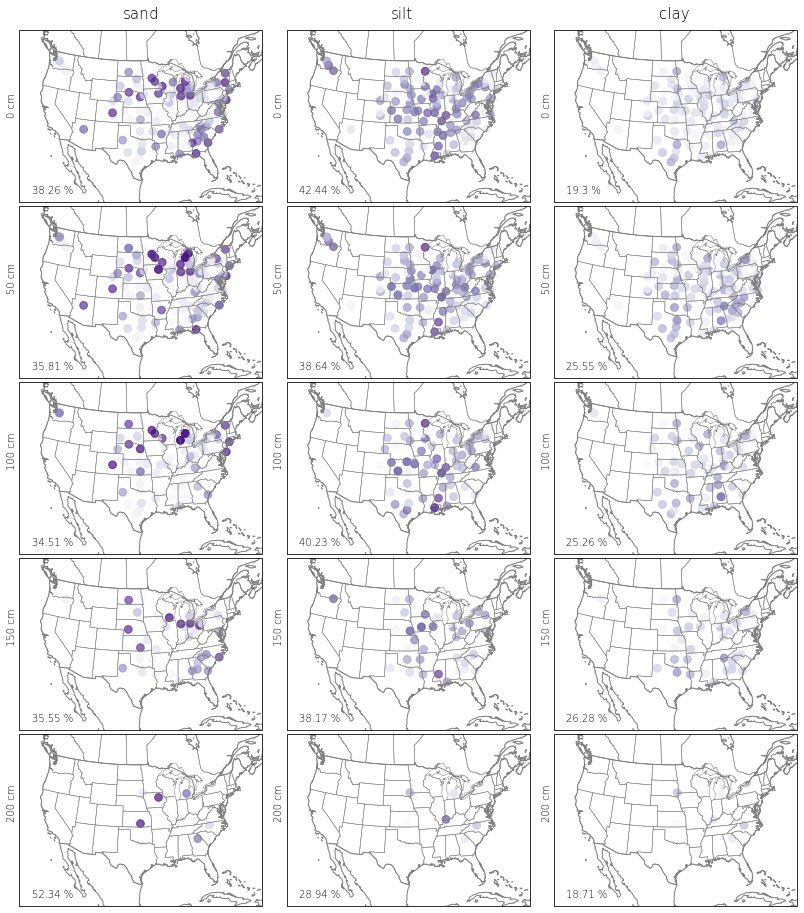

In [19]:
from palettable.colorbrewer.sequential import Purples_9

stypes=['sand', 'silt', 'clay']*5
pmins = [[-1]*3, [0]*3, [50]*3, [100]*3, [150]*3]
pmins = np.concatenate(pmins).tolist()
pmaxs = [[0]*3, [50]*3, [100]*3, [150]*3, [200]*3]
pmaxs = np.concatenate(pmaxs).tolist()

fig = plt.figure(figsize=(12,32))

for i in np.arange(1,16):
    ax = fig.add_subplot(5,3,i, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    
    df_s = df_soils[(df_soils.depth > pmins[i-1]) & (df_soils.depth <= pmaxs[i-1])]

    ax.scatter(df_s.lon, df_s.lat, transform=ccrs.PlateCarree(), s=60,
               c=df_s[stypes[i-1]], vmin=0, vmax=100, cmap=Purples_9.mpl_colormap, alpha=0.7)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.text(0.05, 0.05, str(round(df_s[stypes[i-1]].mean(),2))+' %', transform=ax.transAxes,
            fontweight='light')
    ax.text(-0.05, 0.5, str(pmaxs[i-1]) + ' cm', 
            rotation='vertical', fontweight='light', transform=ax.transAxes)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.1, hspace=-0.89)
fig.text(0.17,0.695, 'sand', fontweight='light', fontsize=15)
fig.text(0.48,0.695, 'silt', fontweight='light', fontsize=15)
fig.text(0.79,0.695, 'clay', fontweight='light', fontsize=15)

#### Map out soil categories at different depth

Such a pain to figure out how to plot these legends, finally found this: <br/>
https://stackoverflow.com/questions/44098362/using-mpatches-patch-for-a-custom-legend/44098900#44098900 <br/>
also checkout here for rectangle legends: <br/>
https://scitools.org.uk/cartopy/docs/latest/gallery/hurricane_katrina.html#sphx-glr-gallery-hurricane-katrina-py

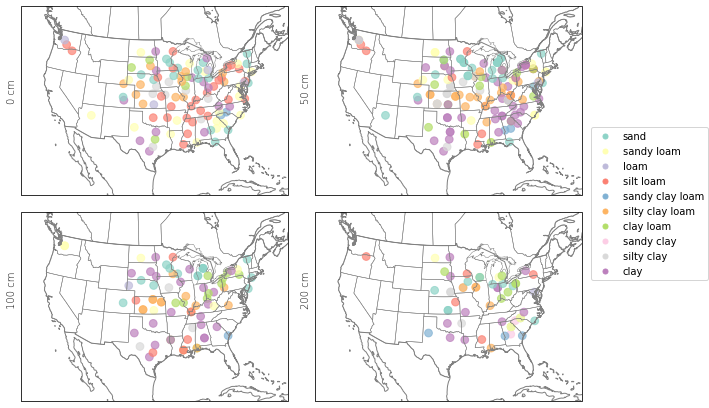

In [233]:
# set up legend 
colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3',
          '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd']
texts = ['sand', 'sandy loam', 'loam', 'silt loam', 'sandy clay loam',
         'silty clay loam', 'clay loam', 'sandy clay', 'silty clay', 'clay']


patches = [plt.plot([],[], marker='o', ms=5, ls='', 
                    color=colors[i], 
                    label=texts[i])[0] for i in range(len(texts)) ]
plt.close()

# plot
pmins = [-1, 0, 50, 100]
pmaxs = [0, 50, 100, 200]
colors = {'sand':'#8dd3c7', 'sandy loam':'#ffffb3', 'loam':'#bebada', 'silt loam':'#fb8072', 'sandy clay loam':'#80b1d3',
          'silty clay loam':'#fdb462', 'clay loam':'#b3de69', 'sandy clay':'#fccde5', 'silty clay':'#d9d9d9', 'clay':'#bc80bd'}

fig = plt.figure(figsize=(10,10))

for i in np.arange(1,5):
    ax = fig.add_subplot(2,2,i, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    
    df_s = df_soils[(df_soils.depth > pmins[i-1]) & (df_soils.depth <= pmaxs[i-1])]

    scatter = ax.scatter(df_s.lon, df_s.lat, transform=ccrs.PlateCarree(), s=60,
                         c=df_s.texture.map(colors), alpha=0.7)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.text(-0.05, 0.5, str(pmaxs[i-1]) + ' cm', 
            rotation='vertical', fontweight='light', transform=ax.transAxes)

fig.legend(handles=patches, loc='right', borderaxespad=0.2)
fig.subplots_adjust(left=0.05, bottom=0, right=0.83, top=1, wspace=0.1, hspace=-0.6)

In [ ]:
# set up legend 
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
texts = ['sand etc.', 'clay loam', 'silt etc.', 'clay']

patches = [plt.plot([],[], marker='o', ms=5, ls='', 
                    color=colors[i], 
                    label=texts[i])[0] for i in range(len(texts)) ]
plt.close()

# plot
pmins = [-1, 0, 50, 100]
pmaxs = [0, 50, 100, 200]
colors = {'1':'#66c2a5', '2':'#fc8d62', '3':'#8da0cb', '4':'#e78ac3'}
texts = ['group1', 'group2', 'group3', 'group4']

fig = plt.figure(figsize=(10,10))

for i in np.arange(1,5):
    ax = fig.add_subplot(2,2,i, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    
    df_s = df_soils[(df_soils.depth > pmins[i-1]) & (df_soils.depth <= pmaxs[i-1])]

    scatter = ax.scatter(df_s.lon, df_s.lat, transform=ccrs.PlateCarree(), s=60,
                         c=df_s.sgroup.map(colors), alpha=0.7)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.text(-0.05, 0.5, str(pmaxs[i-1]) + ' cm', 
            rotation='vertical', fontweight='light', transform=ax.transAxes)

fig.legend(handles=patches, loc='right', borderaxespad=1.8)
fig.subplots_adjust(left=0.05, bottom=0, right=0.83, top=1, wspace=0.1, hspace=-0.6)

In [21]:
import chart_studio
chart_studio.tools.set_credentials_file(username='etismeimet', api_key='chFu99BdYOeCCmUzxeNj')

In [8]:
import chart_studio.plotly as py
import plotly.graph_objects as go

data = py.get_figure("https://plotly.com/~plotly2_demo/455/").data

In [3]:
# this plot is somehow mirror to the USDA soil ternary plot with different soil category names
data